<a href="https://colab.research.google.com/github/FrancescoMonaco/ArcEager/blob/main/Motif_Discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
#@title Basics
!pip install numpy scikit-learn datasketch scipy
!pip install stumpy NearPy
%matplotlib inline
import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt
from numba import cuda
from tqdm import tqdm
import multiprocessing as mp
plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

#Development: Hash->Select->MinHash and variants

In [2]:
#@title Support functions
import numpy as np
from sklearn.random_projection import SparseRandomProjection
from nearpy import Engine
from nearpy.hashes import RandomDiscretizedProjections
from datasketch import MinHashLSH, MinHash
from scipy.spatial.distance import euclidean
import pandas as pd
import matplotlib.pyplot as plt
import queue
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
from itertools import combinations

def euclidean_hash(data, rp):
  return rp.hash_vector(data)

def z_normalized_euclidean_distance(ts1, ts2, random_indices):
    # Ensure both time series have the same dimensions
    if ts1.shape != ts2.shape:
        raise ValueError("Time series must have the same dimensions.")
    # Pick the dimensions used in this iteration
    ts1 = ts1[:,random_indices]
    ts2 = ts2[:,random_indices]

    # Calculate mean and standard deviation for each dimension
    mean_ts1 = np.mean(ts1, axis=0)
    std_ts1 = np.std(ts1, axis=0)

    mean_ts2 = np.mean(ts2, axis=0)
    std_ts2 = np.std(ts2, axis=0)

    sum_sqrd = 0.0

    # z-normalized dist
    for item1, item2 in zip(ts1,ts2):
      sum_sqrd += np.square((((item1-mean_ts1)/std_ts1) - ((item2-mean_ts2)/std_ts2)))

    return np.sum(np.sqrt(sum_sqrd))

def minhash_signature(data, minhasher_seed):
    minhasher = MinHash(num_perm=64, seed=minhasher_seed)
    minhasher.update(np.ascontiguousarray(data))

    return minhasher.copy()

def find_collisions(lsh, query_signature):
    # Query the LSH index for potential collisions
    result = lsh.query(query_signature)

    return result

def truncate(arr, cut):
  arr = np.array([x[:cut] for x in arr])
  return arr

In [ ]:
#@title 1 Parallel S-RP-MP
def projection_cycle(i, all_indices_sets, subsequences, hashed_mat, top, dist_comp, window, lsh_threshold, lock):
    random_gen = np.random.default_rng()
    collided = False
    index_hash = 0
    already_comp = set()
    top = queue.PriorityQueue(maxsize=k+1)
    dist_comp = 0

  # For each column of the matrix
    for hashed_sub in hashed_mat:
      # Find num_comp random numbers between 0 and dimension of time series
      random_indices = [x for x in all_indices_sets]
      pj_ts = [subsequence[0][random_indices] for subsequence in hashed_sub]

      while not collided:
          if index_hash > 0:
              pj_ts= np.apply_along_axis(truncate, 1, pj_ts, 1)
          # Compute fingerprints
              # Create MinHash object
          minhash_seed = random_gen.integers(0, 2**32 - 1)
          minhash_signatures = []

          for projected_subsequence in pj_ts:
              minhash_sig = minhash_signature(projected_subsequence, minhash_seed)
              minhash_signatures.append(minhash_sig)
          lsh = MinHashLSH(threshold=lsh_threshold, num_perm=64)
          for ik, signature in enumerate(minhash_signatures):
              lsh.insert(ik, signature)

          for j, minhash_sig in enumerate(minhash_signatures):
                  collisions = lsh.query(minhash_sig)
                  #print(collisions)
                  if len(collisions) > 1:
                      collided = True
                      # Remove trivial matches, same subsequence or overlapping subsequences
                      collisions = [sorted((j, c)) for c in collisions if c != j and abs(c - j) > window]
                      #print(collisions)
                      curr_dist = 0

                      for collision in collisions:
                          add = True
                        # If we already computed this couple skip
                          if tuple(collision) in already_comp:
                            add=False
                            break
                        # If already inserted skip
                          if( any(collision == stored_el1 for _, (_, stored_el1) in top.queue)):
                              add = False
                              break
                          # Check overlap with the already computed
                          for stored in top.queue:
                            #Access the collision
                            stored_dist = abs(stored[0])
                            stored_el = stored[1]
                            stored_el1 = stored_el[1]
                            #stored = stored[1][0]
                            # If it's an overlap of both indices, keep the one with the smallest distance
                            if (abs(collision[0] - stored_el1[0]) < window or
                                abs(collision[1] - stored_el1[1]) < window):
                                curr_dist = z_normalized_euclidean_distance(subsequences[collision[0]], subsequences[collision[1]], random_indices)
                                if curr_dist < stored_dist:
                                  top.queue.remove(stored)
                                  top.put((-curr_dist, [dist_comp, collision]))
                                  already_comp.add(tuple(collision))
                                  add = False
                                  break

                          # Add to top with the projection index
                          if add:
                            dist_comp +=1
                            distance = z_normalized_euclidean_distance(subsequences[collision[0]], subsequences[collision[1]], random_indices)
                            top.put((-distance, [dist_comp , collision]))
                            already_comp.add(tuple(collision))
                            if top.full(): top.get(block=False)

          # Repeat with K-1 hashes
          if not collided:
              index_hash +=1

    return top, dist_comp


def pmotif_find(time_series, window, projection_iter, k, project_comp, bin_width, lsh_threshold, L, K):
    random_gen = np.random.default_rng()
  # Data
    dimension = time_series.shape[1]
    num_comp = project_comp
    top = queue.PriorityQueue(maxsize=(k+1))
  # Extract all subsequences
    subsequences = []
    hash_mat = []
    index_hash = 0
    dist_comp = 0
  # Hasher
    rp = []
    engines = []
    # Create the repetitions for the LSH
    for i in range(L):
      rps= RandomDiscretizedProjections('rp', K, bin_width)
      engine = Engine(window, lshashes=[rps])
      rp.append(rps)
      engines.append(engine)


  #Projection sets
    # Generate a pool of indices
    index_pool = combinations(range(dimension), project_comp)
    index_pool = [x for x in index_pool]
    # Shuffle the pool to ensure randomness
    random_gen.shuffle(index_pool)
    print(index_pool)

    for i in range(len(time_series) - window + 1):
        hashed_sub = []
        subsequence = time_series[i:i + window]
        subsequences.append(subsequence)
        subsequence = (subsequence - np.mean(subsequence)) / np.std(subsequence)
        for rp_temp in rp:
          hashed_sub.append(np.apply_along_axis(euclidean_hash, 0, subsequence, rp_temp))
        # Insert into the matrix at the corresponding row
        hash_mat.append(hashed_sub)
    hash_mat = list(map(list, zip(*hash_mat)))
    print("Hashing finished")
    lock = threading.Lock()

    with ThreadPoolExecutor() as executor:
      result = {executor.submit(projection_cycle, i, index_pool[i%len(index_pool)], subsequences, hash_mat, top, dist_comp, window, lsh_threshold, lock) for i in range(projection_iter)}
      with tqdm(total=projection_iter, desc="Iteration") as pbar:
        for future in as_completed(result):
          top_i, dist_comp_i = future.result()
          pbar.update(1)

          with lock:
            top.queue.extend(top_i.queue)
            dist_comp += dist_comp_i

            # Order the queue
            top.queue.sort(reverse=True)
    #Remove overlapping tuples inside the queue
    for id, elem in enumerate(top.queue):
      for elem2 in top.queue[id+1:]:
        if (abs(elem[1][1][0] - elem2[1][1][0]) < window or
            abs(elem[1][1][1] - elem2[1][1][1]) < window):
          if abs(elem[0]) > abs(elem2[0]):
            top.queue.remove(elem)
          else:
            top.queue.remove(elem2)
    top.queue = top.queue[:k]
    return top, dist_comp

In [ ]:
#@title 2 Parallel RP-MP
def minhash_cycle(i, original, subsequences, k, dist_comp, window, lsh_threshold):
        top = queue.PriorityQueue(k+1)
        dimension = subsequences[0].shape[1]
        random_gen = np.random.default_rng()
        #Save the couples that we already computed in this iteration
        already_comp = set()
        pj_ts = subsequences
        index_hash=0
        collided = False
        while not collided:
            if index_hash > 0:
                pj_ts= np.apply_along_axis(truncate, 1, pj_ts, 1)
            # Compute fingerprints
                # Create MinHash object
            minhash_seed = random_gen.integers(0, 2**32 - 1)
            minhash_signatures = []

            for projected_subsequence in pj_ts:
                minhash_sig = minhash_signature(projected_subsequence, minhash_seed)
                minhash_signatures.append(minhash_sig)
            lsh = MinHashLSH(threshold=lsh_threshold, num_perm=64)
            for ik, signature in enumerate(minhash_signatures):
                lsh.insert(ik, signature)
            # Find collisions
            for j, minhash_sig in enumerate(minhash_signatures):
                    collisions = lsh.query(minhash_sig)
                    #print(collisions)
                    if len(collisions) > 1:
                        collided = True
                        # Remove trivial matches, same subsequence or overlapping subsequences
                        collisions = [sorted((j, c)) for c in collisions if c != j and abs(c - j) > window]
                        #print(collisions)
                        curr_dist = 0
                        for collision in collisions:
                            add = True

                        # If we already computed this couple skip
                            if tuple(collision) in already_comp:
                                add=False
                                break
                        # If already inserted skip
                            if( any(collision == stored_el1 for _, (_, stored_el1) in top.queue)):
                                add = False
                                break

                            # Check overlap with the already computed
                            for stored in top.queue:
                                #Access the collision
                                stored_dist = abs(stored[0])
                                stored_el = stored[1]
                                stored_el1 = stored_el[1]
                                #stored = stored[1][0]
                                # If it's an overlap of both indices, keep the one with the smallest distance
                                if (abs(collision[0] - stored_el1[0]) < window or
                                    abs(collision[1] - stored_el1[1]) < window or
                                    abs(collision[0] - stored_el1[1]) < window or
                                    abs(collision[1] - stored_el1[0]) < window):
                                    curr_dist = z_normalized_euclidean_distance(original[collision[0]], original[collision[1]], np.arange(dimension))
                                    if curr_dist < stored_dist:
                                        top.queue.remove(stored)
                                        top.put((-curr_dist, [dist_comp, collision]))
                                        already_comp.add(tuple(collision))
                                    add = False
                                    break

                            # Add to top with the projection index
                            if add:
                                dist_comp +=1
                                distance = z_normalized_euclidean_distance(original[collision[0]], original[collision[1]], np.arange(dimension))
                                top.put((-distance, [dist_comp , collision]))
                                already_comp.add(tuple(collision))
                                if top.full(): top.get(block=False)
            # Repeat with K-1 hashes
            if not collided:
                index_hash +=1

    # Return top k collisions
        return top, dist_comp

def pmotif_find2(time_series, window, projection_iter, k, project_comp, bin_width, lsh_threshold, L, K):
    random_gen = np.random.default_rng()
  # Data
    dimension = time_series.shape[1]
    num_comp = project_comp
    top = queue.PriorityQueue(maxsize=k+1)
  # Extract all subsequences
    subsequences = []
    hash_mat = []
    index_hash = 0
    dist_comp = 0
  # Hasher
    n_projections = K
    engines= []
    rp = []
    # Create the repetitions for the LSH
    for i in range(L):
      rps= RandomDiscretizedProjections('rp', n_projections, bin_width)
      engine = Engine(window, lshashes=[rps])
      rp.append(rps)
      engines.append(engine)

    for i in range(len(time_series) - window + 1):
        hashed_sub = []
        subsequence = time_series[i:i + window]
        subsequences.append(subsequence)
        subsequence = (subsequence - np.mean(subsequence)) / np.std(subsequence)
        for rp_temp in rp:
          hashed_sub.append(np.apply_along_axis(euclidean_hash, 0, subsequence, rp_temp))
        # Insert into the matrix at the corresponding row
        hash_mat.append(hashed_sub)
    hash_mat = list(map(list, zip(*hash_mat)))
    print("Hashing finished")
    lock = threading.Lock()

    with ThreadPoolExecutor() as executor:
      result = {executor.submit(minhash_cycle, i, subsequences, hash_mat[i], k,dist_comp, window, lsh_threshold) for i in range(projection_iter)}
      with tqdm(total=projection_iter, desc="Iteration") as pbar:
        for future in as_completed(result):
          top_i, dist_comp_i = future.result()
          pbar.update(1)
          print("Wait lock")
          with lock:
            print("Acquired lock")
            top.queue.extend(top_i.queue)
            dist_comp += dist_comp_i

            # Order the queue
            top.queue.sort(reverse=True)
    #Remove overlapping tuples inside the queue
    print("Len", len(top.queue))
    for id, elem in enumerate(top.queue):
      for elem2 in top.queue[id+1:]:
        if (abs(elem[1][1][0] - elem2[1][1][0]) < window or
            abs(elem[1][1][1] - elem2[1][1][1]) < window or
            abs(elem[1][1][0] - elem2[1][1][1]) < window or
            abs(elem[1][1][1] - elem2[1][1][0]) < window):
          if abs(elem[0]) > abs(elem2[0]):
            top.queue.remove(elem)
          else:
            top.queue.remove(elem2)
    top.queue = top.queue[:k]
    return top, dist_comp

In [9]:
#@title 3 S-RP
def dimension_cycle(f, subsequences, hashed_mat, k, dist_comp, window, lsh_threshold):
    collided = False
    index_hash = 0
    already_comp = set()
    top = queue.PriorityQueue(maxsize=k+1)
    dist_comp = 0
    for hashed_sub in hashed_mat:
      hash_groups = {}
    # Extract the projection indices
      pj_ts = [subsequence[0][f] for subsequence in hashed_sub]
    # If two hashes are the same, we have a collision
      while not collided:
            # Group equal hashes
            for j, hash_val in enumerate(pj_ts):
                if hash_val not in hash_groups:
                    hash_groups[hash_val] = []
                hash_groups[hash_val].append(j)
            # Check for trivial matches within each hash group
            for indices in hash_groups.values():
                if len(indices) > 1:
                    #collided = True
                    for i in range(len(indices)):
                        for j in range(i+1, len(indices)):
                            if abs(indices[i] - indices[j]) > window:
                              sort_idx = sorted((indices[i], indices[j]))
                              if not tuple(sort_idx) in already_comp:
                                dist_comp += 1
                                distance = z_normalized_euclidean_distance(subsequences[indices[i]], subsequences[indices[j]], [f])
                                top.put((-distance, [dist_comp, sort_idx, f]))
                                already_comp.add(tuple(sort_idx))
                                if top.full(): top.get(block=False)
            # Repeat with K-1 hashes
            if not collided:
                index_hash +=1
                if index_hash > 0:
                    pj_ts= np.apply_along_axis(truncate, 0, pj_ts, 1)
                if index_hash == 3:
                  collided = True
    return top, dist_comp


def pmotif_find3(time_series, window, projection_iter, k, project_comp, bin_width, lsh_threshold, L, K):
    random_gen = np.random.default_rng()
  # Data
    dimension = time_series.shape[1]
    num_comp = project_comp
    top = queue.PriorityQueue(maxsize=k+1)
  # Extract all subsequences
    subsequences = []
    hash_mat = []
    index_hash = 0
    dist_comp = 0
  # Hasher
    n_projections = K
    engines= []
    rp = []
    # Create the repetitions for the LSH
    for i in range(L):
      rps= RandomDiscretizedProjections('rp', n_projections, bin_width)
      engine = Engine(window, lshashes=[rps])
      rp.append(rps)
      engines.append(engine)

    for i in range(len(time_series) - window + 1):
        hashed_sub = []
        subsequence = time_series[i:i + window]
        subsequences.append(subsequence)
        subsequence = (subsequence - np.mean(subsequence)) / np.std(subsequence)
        for rp_temp in rp:
          hashed_sub.append(np.apply_along_axis(euclidean_hash, 0, subsequence, rp_temp))
        # Insert into the matrix at the corresponding row
        hash_mat.append(hashed_sub)
    hash_mat = list(map(list, zip(*hash_mat)))
    print("Hashing finished")
    lock = threading.Lock()

    with ThreadPoolExecutor() as executor:
      result = {executor.submit(dimension_cycle, i, subsequences, hash_mat, k,dist_comp, window, lsh_threshold) for i in range(projection_iter)}
      with tqdm(total=projection_iter, desc="Iteration") as pbar:
        for future in as_completed(result):
          top_i, dist_comp_i = future.result()
          pbar.update(1)
          print("Wait lock")
          with lock:
            print("Acquired lock")
            top.queue.extend(top_i.queue)
            dist_comp += dist_comp_i

            # Order the queue
            top.queue.sort(reverse=True)
    #Remove overlapping tuples inside the queue
    print("Len", len(top.queue))
    '''
    for id, elem in enumerate(top.queue):
      for elem2 in top.queue[id+1:]:
        if (abs(elem[1][1][0] - elem2[1][1][0]) < window or
            abs(elem[1][1][1] - elem2[1][1][1]) < window or
            abs(elem[1][1][0] - elem2[1][1][1]) < window or
            abs(elem[1][1][1] - elem2[1][1][0]) < window):
          if abs(elem[0]) > abs(elem2[0]):
            top.queue.remove(elem)
          else:
            top.queue.remove(elem2)
    top.queue = top.queue[:k]
    '''
    return top, dist_comp

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
Hashing finished


Iteration: 100%|██████████| 3/3 [00:00<00:00, 193.24it/s]


Wait lock
Acquired lock
Wait lock
Acquired lock
Wait lock
Acquired lock
Len 5
11


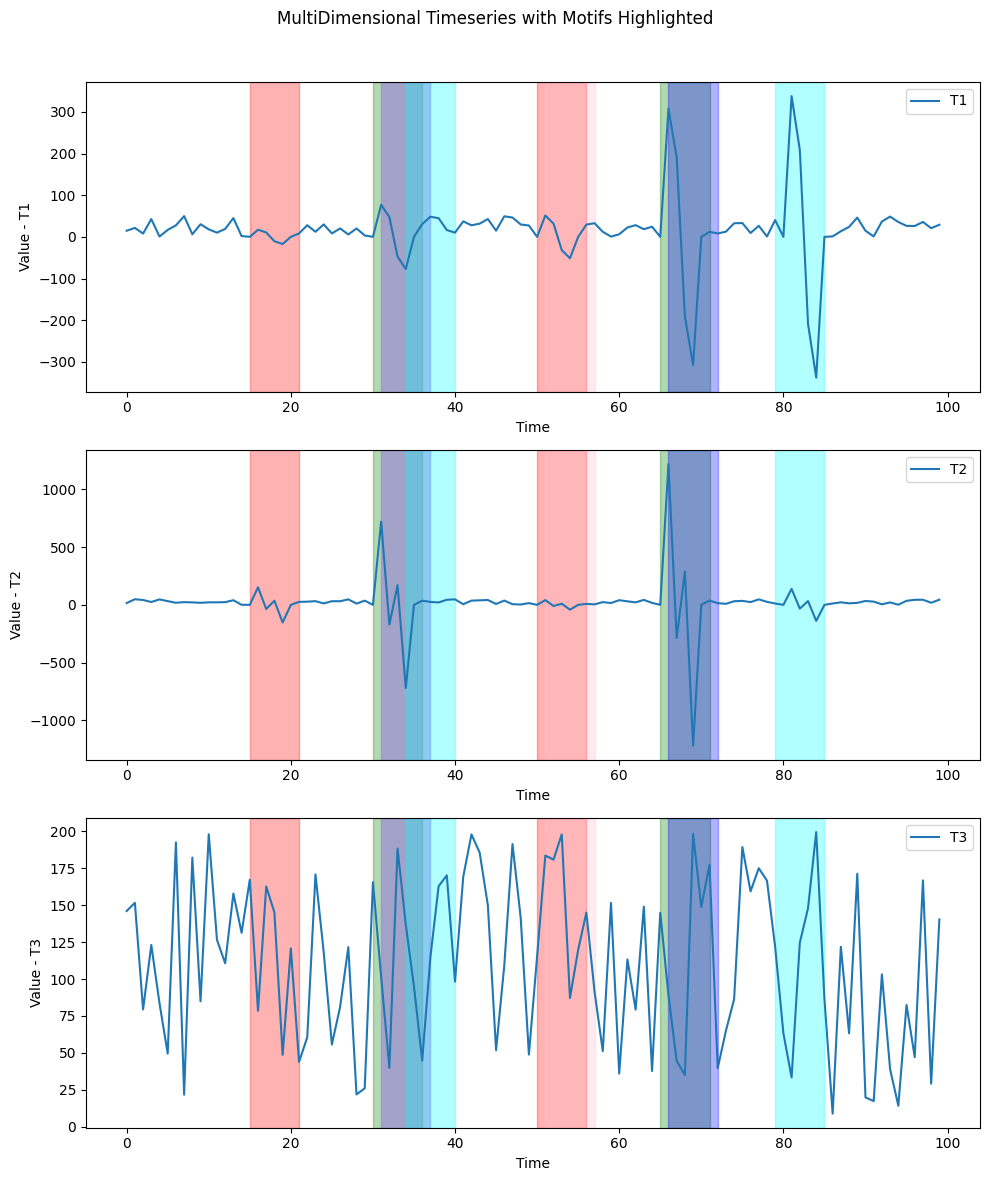

In [7]:
#@title Example 1

timeseries = np.random.rand(100) * 50
timeseries = timeseries.astype(float)

# Plant motifs at specific locations
motif_length = 6
motif = 4.5 * np.sin(np.linspace(0, 2 * np.pi, motif_length))

# Plant the motif at specific locations
motif_locations = [15, 30, 50, 65, 80]

for loc in motif_locations:
    motif_place = motif * np.random.randint(1, 100)
    timeseries[loc:loc+motif_length] = motif_place
# Create sample 3-dimensional timeseries
timeseries_3d = np.random.rand(100, 3) * 50
timeseries_3d[:, 0] = timeseries  # One dimension is the same as the unidimensional time series

# Plant motifs at specific locations in the second dimension
motif_length = 6
motif = 4.5 * np.tan(np.linspace(0, 2 * np.pi, motif_length))

# Plant the motif at specific locations in the second dimension
motif_locations = [15, 30, 50, 65, 80]

for loc in motif_locations:
    motif_place = motif * np.random.randint(1, 100)
    timeseries_3d[loc:loc+motif_length, 1] = motif_place

# The third dimension is just noise
timeseries_3d[:, 2] = np.random.rand(100)*200

# Set parameters
window_size = 6
lsh_threshold = 0.8
projection_iter = 3
k = 2

# Pick the subsequences where the motifs are located
rp = RandomDiscretizedProjections('rp', 10, 10)
engine = Engine(window_size, lshashes=[rp])

subsequences = []
for index in motif_locations:
    subsequences.append(timeseries_3d[index:index+window_size])
norm =  []
# Compute their z-normalization
for subsequence in subsequences:
    subsequence = (subsequence - np.mean(subsequence)) / np.std(subsequence)
    norm.append(subsequence)

# Compute the Jaccard similarity between the subsequences
jaccard_sim = np.zeros((len(subsequences), len(subsequences)))
for i, subsequence1 in enumerate(norm):
    for j, subsequence2 in enumerate(norm):
        # Find the intersection and union of the subsequences
        intersection = np.intersect1d(subsequence1, subsequence2)
        union = np.union1d(subsequence1, subsequence2)
        jaccard_sim[i, j] = len(intersection) / len(union)
        hash1 = np.apply_along_axis(euclidean_hash, 0 , subsequence1, rp)
        #print(hash1)


print(jaccard_sim)

# Find motifs
motifs, dist_comp = pmotif_find3(timeseries_3d, window_size, projection_iter, k, 2, 4, lsh_threshold, 3, 32)
motifs = motifs.queue
print(dist_comp)
# Plot the original time series and highlight the motifs, find the motifs in all the time series
df = pd.DataFrame(timeseries_3d, columns=['T1', 'T2', 'T3'])

# Plot 3 subplots, one for each dimension
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
colors = ["red", "green", "blue", "pink", "cyan", "yellow", "orange", "gray", "purple"]
for i, dimension in enumerate(['T1', 'T2', 'T3']):
    axs[i].plot(df[dimension], label=dimension)
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel(f"Value - {dimension}")
    axs[i].legend()

    for idx, motif in enumerate(motifs):
        # Highlight the motifs in all dimensions
        for m in motif[1][1]:
            axs[i].axvspan(m, m + window_size, color=colors[idx], alpha=0.3)

plt.suptitle("MultiDimensional Timeseries with Motifs Highlighted")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Hashing finished


Iteration:  33%|███▎      | 1/3 [01:29<02:59, 89.56s/it]

Wait lock
Acquired lock


Iteration:  67%|██████▋   | 2/3 [01:29<00:37, 37.09s/it]

Wait lock
Acquired lock


Iteration: 100%|██████████| 3/3 [01:31<00:00, 30.60s/it]


Wait lock
Acquired lock
Len 9
185570


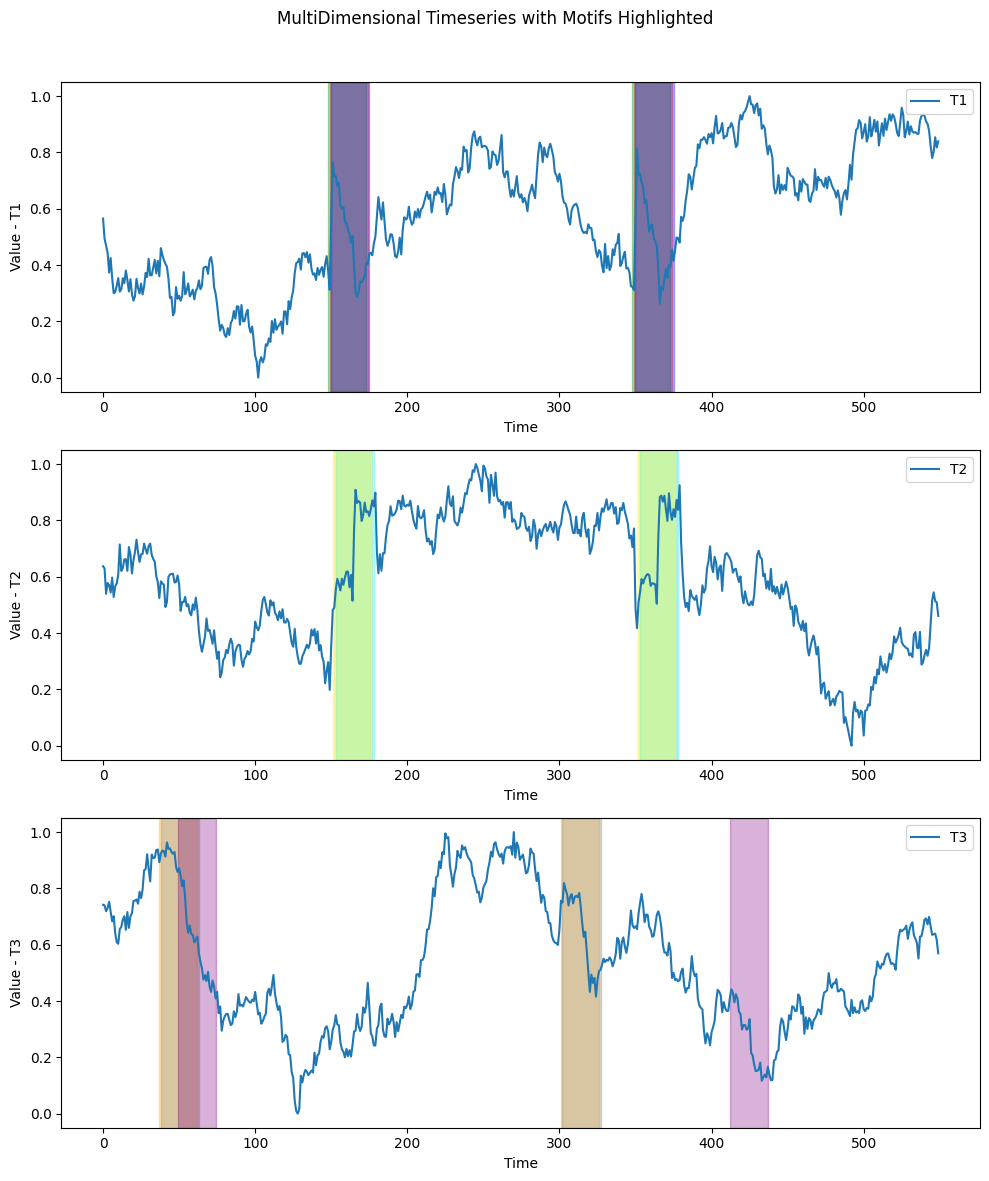

In [10]:
#@title Example 2 - Priority
df = pd.read_csv("https://zenodo.org/record/4328047/files/toy.csv?download=1")
ts_test = df.to_numpy()

# Set parameters
window_size = 25
lsh_threshold = 0.80
projection_iter = 3
k = 3
proj= 2
colors = ["red", "green", "blue", "pink", "cyan", "yellow", "orange", "gray", "purple"]

motifs, distance_comp = pmotif_find3(ts_test, window_size, projection_iter, k, proj, 10,lsh_threshold, 3, 32)
print(distance_comp)
motifs = motifs.queue
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
for i, dimension in enumerate(df.columns):
    axs[i].plot(df[dimension], label=dimension)
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel(f"Value - {dimension}")
    axs[i].legend()

    for idx, motif in enumerate(motifs):
        # Highlight the motifs in all dimensions
        for m in motif[1][1]:
          if motif[1][2] == i:
            axs[i].axvspan(m, m + window_size, color=colors[idx], alpha=0.3)

plt.suptitle("MultiDimensional Timeseries with Motifs Highlighted")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Stumpy

In [ ]:
if __name__ == "__main__":
    df = pd.read_csv("https://zenodo.org/record/4328047/files/toy.csv?download=1")
    #your_time_series = np.random.rand(10000)
    window_size = 30  # Approximately, how many data points might be found in a pattern
    #all_gpu_devices = [device.id for device in cuda.list_devices()]  # Get a list of all available GPU devices

    matrix_profile, matrix_profile_idx = stumpy.mstump(df, m=window_size)

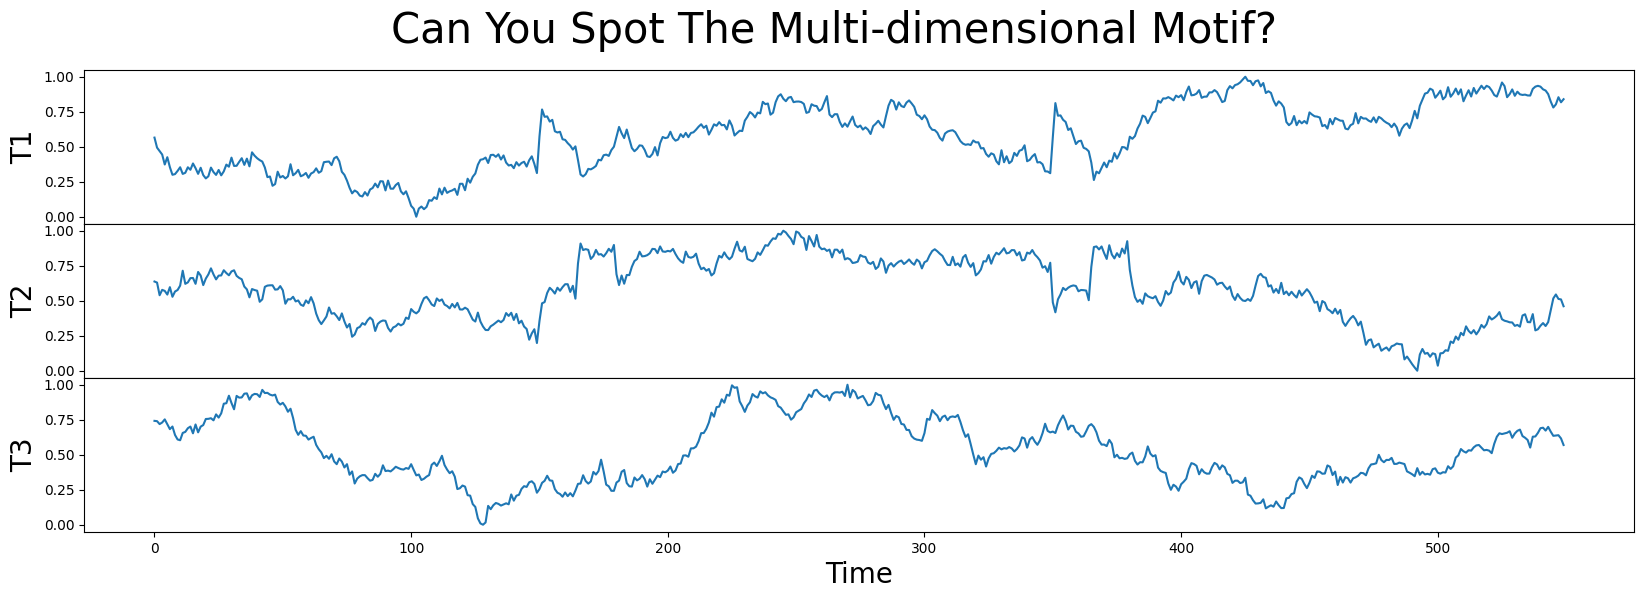

In [ ]:
fig, axs = plt.subplots(df.shape[1], sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Can You Spot The Multi-dimensional Motif?', fontsize='30')

for i in range(df.shape[1]):
    axs[i].set_ylabel(f'T{i + 1}', fontsize='20')
    axs[i].set_xlabel('Time', fontsize ='20')
    axs[i].plot(df[f'T{i + 1}'])

plt.show()

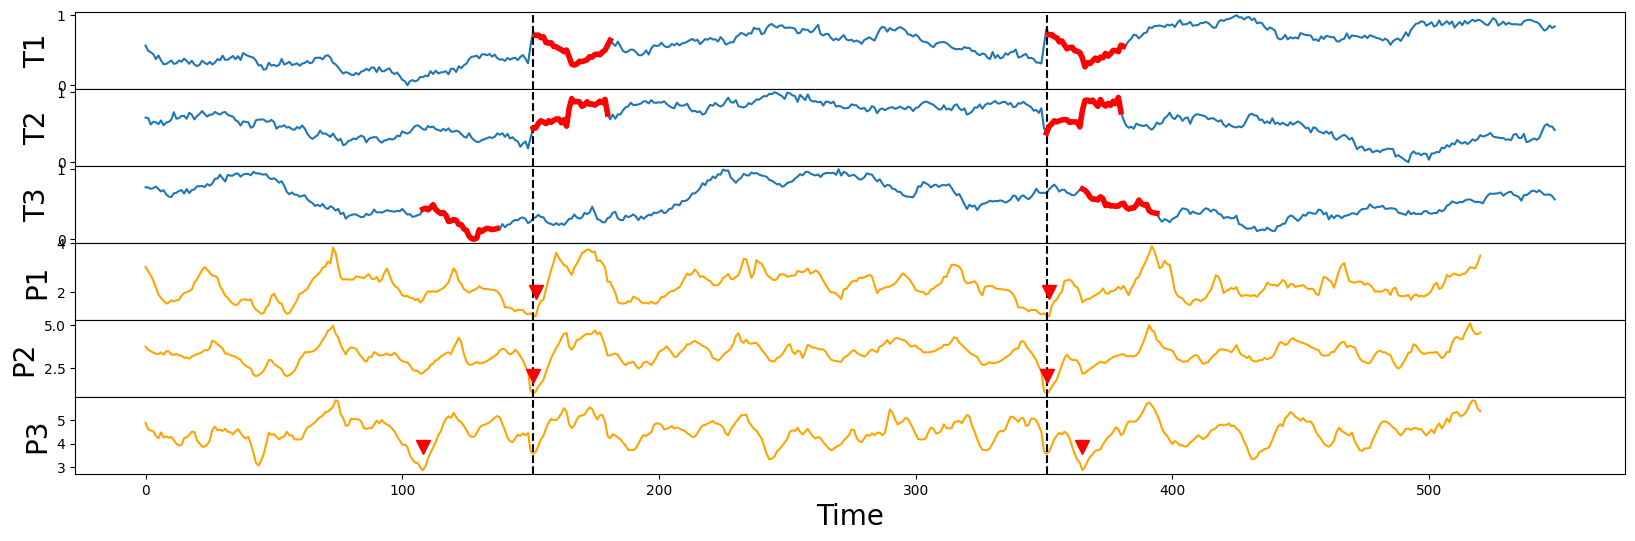

In [ ]:
motifs_idx = np.argmin(matrix_profile, axis=1)
nn_idx = matrix_profile_idx[np.arange(len(motifs_idx)), motifs_idx]
m = window_size
fig, axs = plt.subplots(matrix_profile.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 0})

for k, dim_name in enumerate(df.columns):
    axs[k].set_ylabel(dim_name, fontsize='20')
    axs[k].plot(df[dim_name])
    axs[k].set_xlabel('Time', fontsize ='20')

    axs[k + matrix_profile.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='20')
    axs[k + matrix_profile.shape[0]].plot(matrix_profile[k], c='orange')
    axs[k + matrix_profile.shape[0]].set_xlabel('Time', fontsize ='20')

    axs[k].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k].axvline(x=nn_idx[1], linestyle="dashed", c='black')
    axs[k + matrix_profile.shape[0]].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k + matrix_profile.shape[0]].axvline(x=nn_idx[1], linestyle="dashed", c='black')

    #if dim_name != 'T3':
    axs[k].plot(range(motifs_idx[k], motifs_idx[k] + m), df[dim_name].iloc[motifs_idx[k] : motifs_idx[k] + m], c='red', linewidth=4)
    axs[k].plot(range(nn_idx[k], nn_idx[k] + m), df[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
    axs[k + matrix_profile.shape[0]].plot(motifs_idx[k], matrix_profile[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='red')
    axs[k + matrix_profile.shape[0]].plot(nn_idx[k], matrix_profile[k, nn_idx[k]] + 1, marker="v", markersize=10, color='red')

plt.show()

#ATTIMO

In [ ]:
!pip install pyattimo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.3 MB/s eta 0:00:00


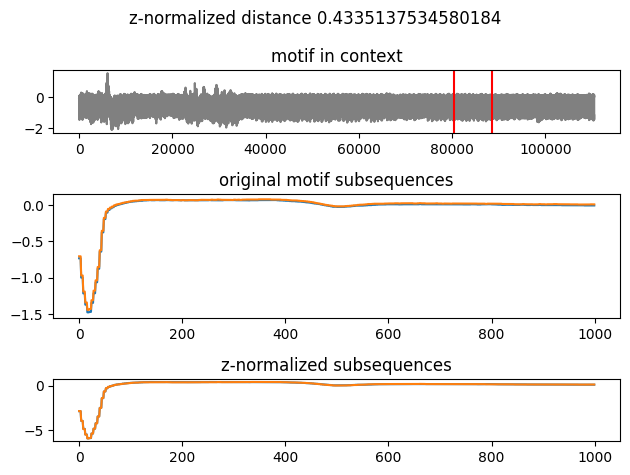

In [ ]:
import pyattimo

# Load an example time series
ts = pyattimo.load_dataset("ecg", prefix=1000000)

# Create the motifs iterator
motifs = pyattimo.MotifsIterator(ts, w=1000, max_k=100)

# Get the top motif via the iterator interface
m = next(motifs)

# Plot the motif just obtained
m.plot()

#AEON data

In [ ]:
import os
!pip install aeon ucimlrepo
import aeon
from aeon.datasets import load_from_tsfile
from aeon.datasets import load_classification

X, y = load_classification("MotionSenseHAR")
print(" Shape of X = ", X.shape)

 Shape of X =  (1231, 12, 1000)


In [ ]:
pick = np.abs(X[:,:,1])
print(pick.shape)
matrix_profile, matrix_profile_idx = stumpy.mstump(pick, m=8)

(1231, 12)


ValueError: Automatic legend placement (loc='best') not implemented for figure legend

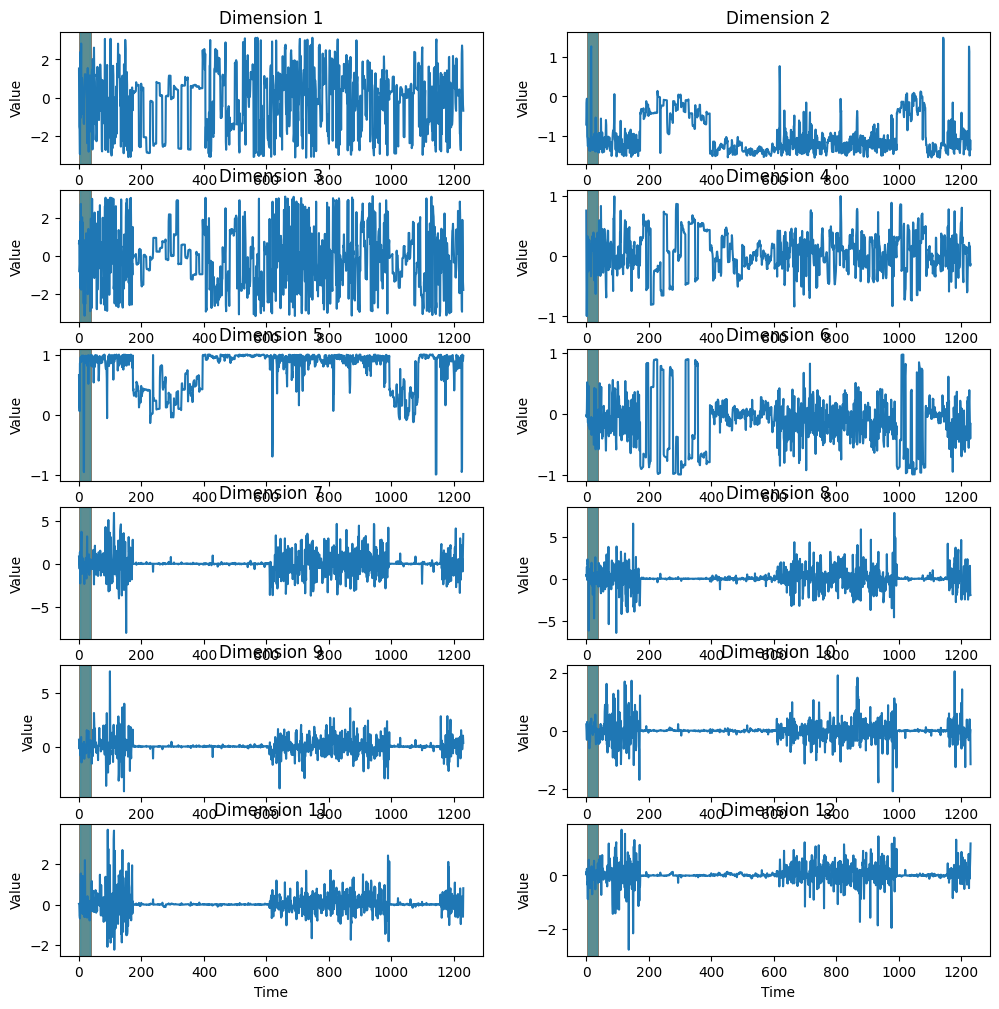

In [ ]:
top_3_motifs_per_dim = {}

import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 2, figsize=(12, 12))  # Adjust figsize as needed

for dim, ax in enumerate(axes.flat):
    ax.plot(X[:, dim,1])  # Plot original timeseries for each dimension
    title = f"Dimension {dim+1}"
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")

    # Highlight top 3 motifs in each dimension
    top_3_indices = matrix_profile_idx[:,1]
    for i, motif_index in enumerate(top_3_indices):
        start_index = motif_index
        end_index = start_index + window_size
        ax.axvspan(start_index, end_index, color=f'C{i}', alpha=0.3, label=f"Motif {i+1}")

fig.legend(loc='best')  # Adjust legend placement as needed
plt.tight_layout()
plt.show()


In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
air_quality = fetch_ucirepo(id=360)

# data (as pandas dataframes)
X = air_quality.data.features
print(air_quality.metadata)

{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Fri Oct 27 2023', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': None, 'additional_info': {'summary': 'The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded i

In [ ]:
X = X.iloc[:,2:]
matrix_profile, matrix_profile_idx = stumpy.mstump(X, m=30)

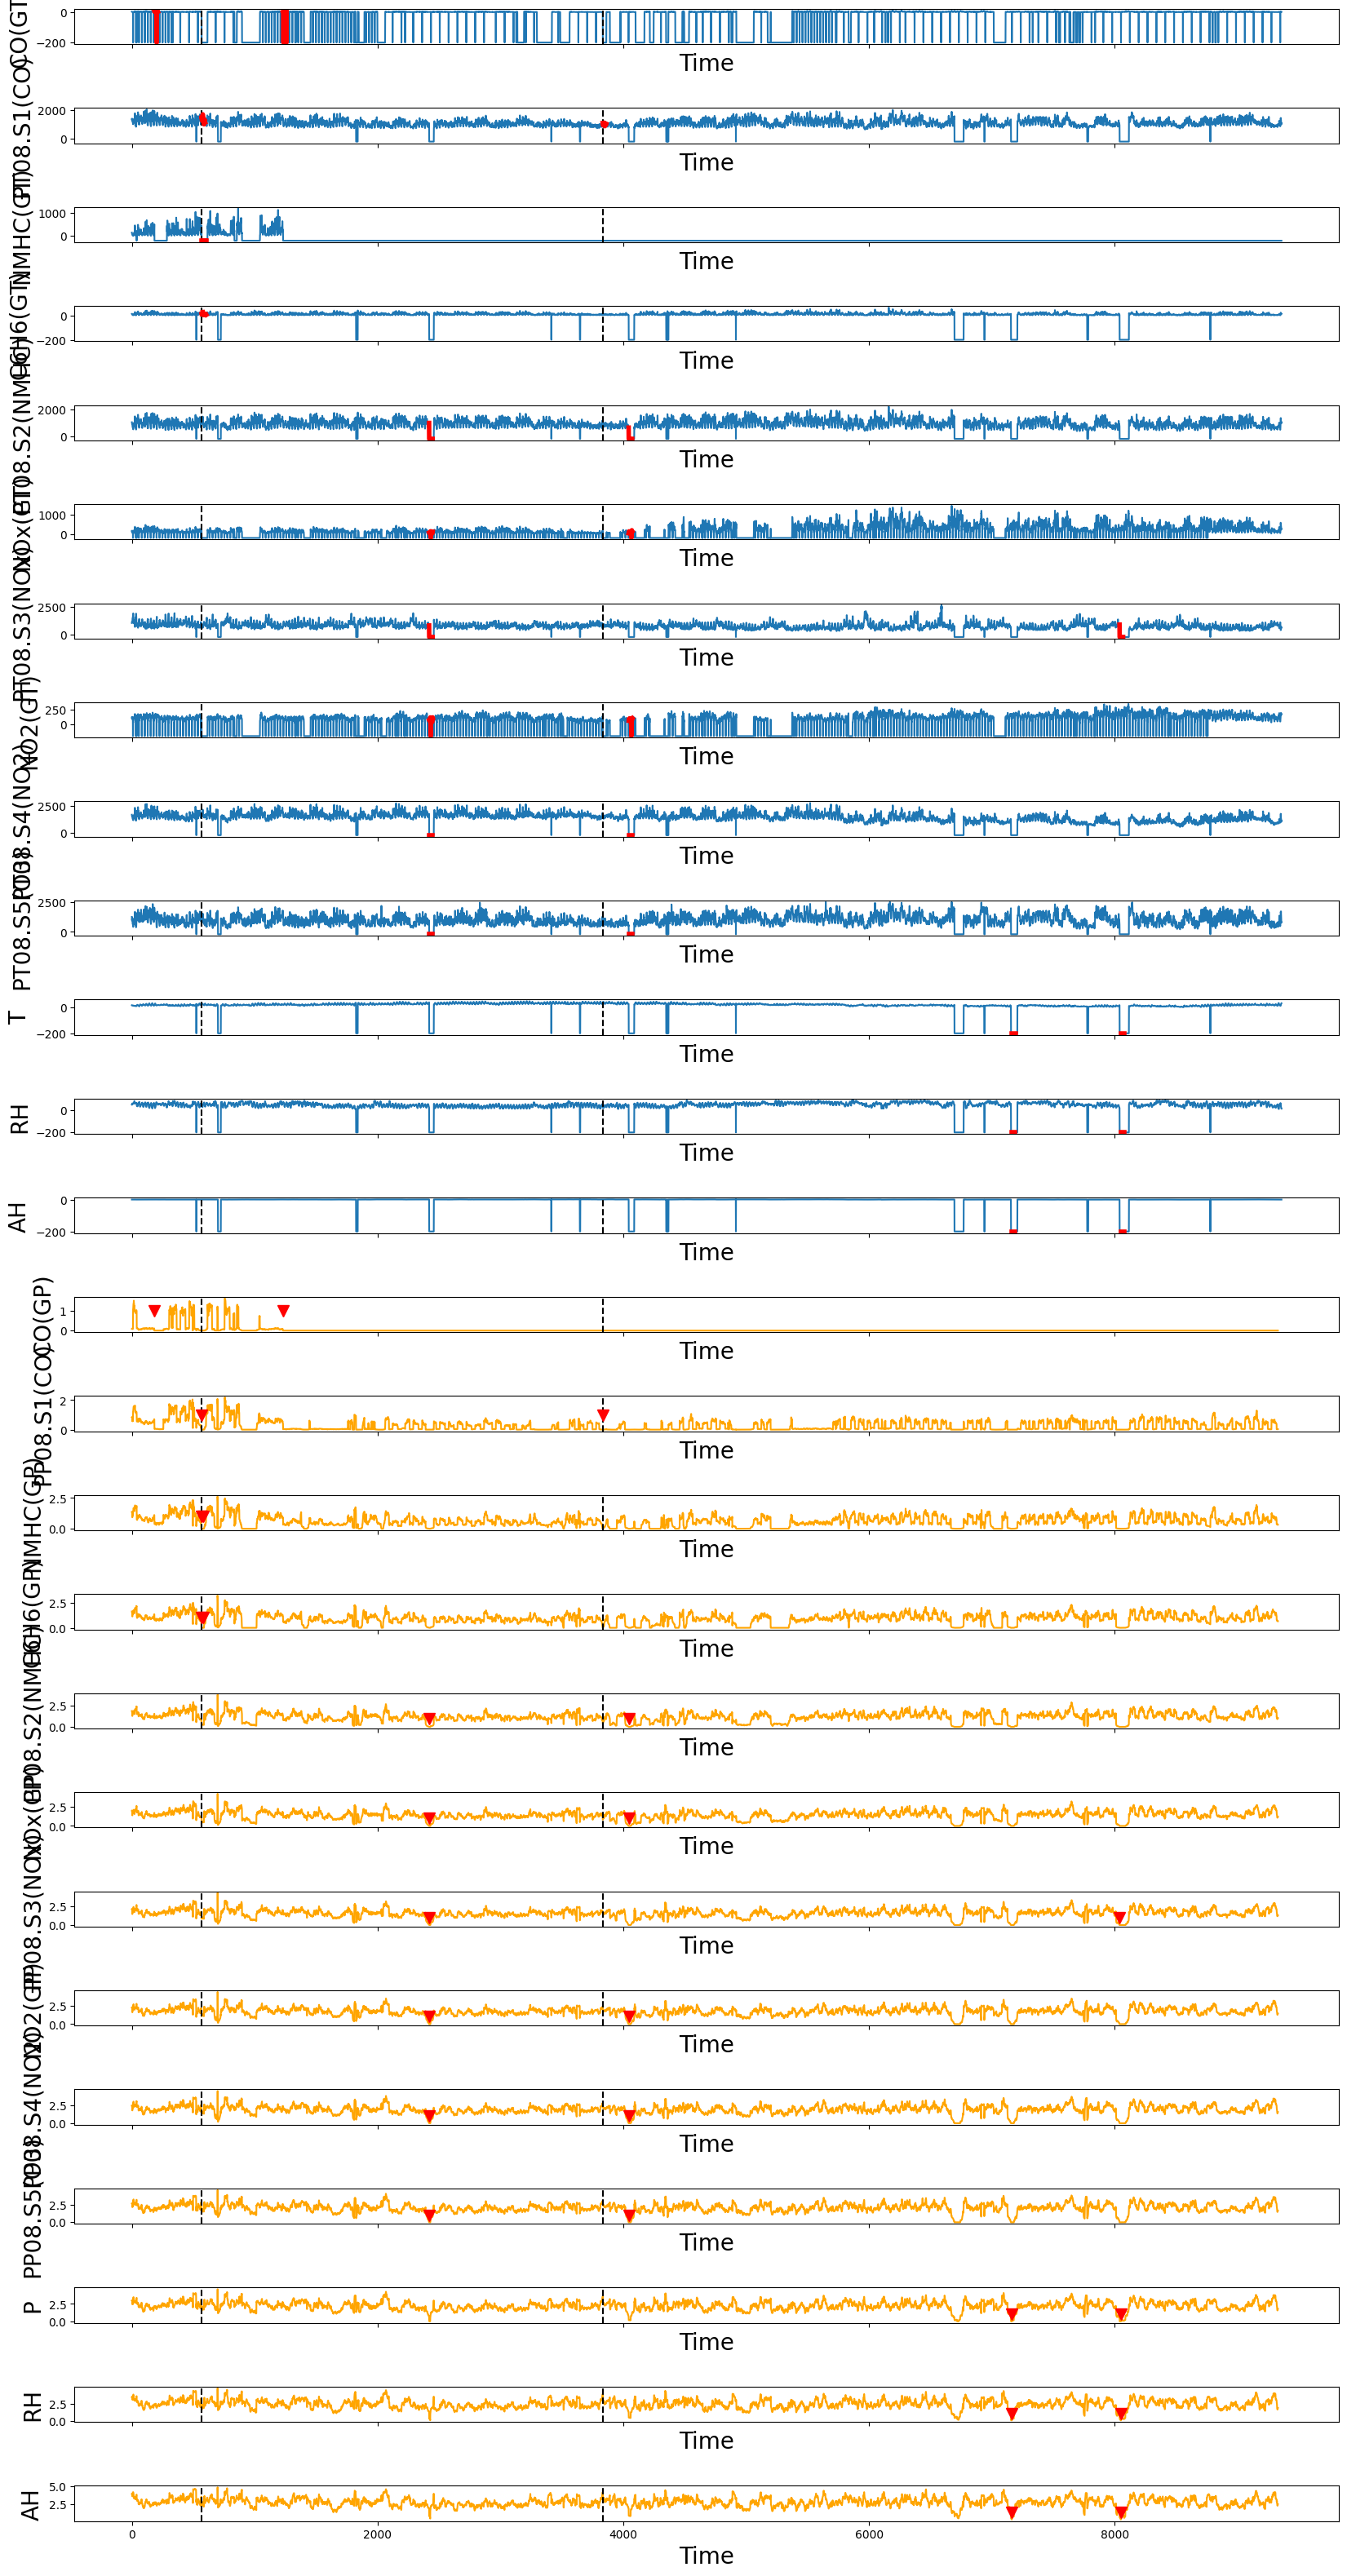

In [ ]:
motifs_idx = np.argmin(matrix_profile, axis=1)
nn_idx = matrix_profile_idx[np.arange(len(motifs_idx)), motifs_idx]
m = 30
fig, axs = plt.subplots(matrix_profile.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 1.8}, figsize=(20,40))

for k, dim_name in enumerate(X.columns):
    axs[k].set_ylabel(dim_name, fontsize='20')
    axs[k].plot(X[dim_name])
    axs[k].set_xlabel('Time', fontsize ='20')

    axs[k + matrix_profile.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='20')
    axs[k + matrix_profile.shape[0]].plot(matrix_profile[k], c='orange')
    axs[k + matrix_profile.shape[0]].set_xlabel('Time', fontsize ='20')

    axs[k].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k].axvline(x=nn_idx[1], linestyle="dashed", c='black')
    axs[k + matrix_profile.shape[0]].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k + matrix_profile.shape[0]].axvline(x=nn_idx[1], linestyle="dashed", c='black')

    #if dim_name != 'T3':
    axs[k].plot(range(motifs_idx[k], motifs_idx[k] + m), X[dim_name].iloc[motifs_idx[k] : motifs_idx[k] + m], c='red', linewidth=4)
    axs[k].plot(range(nn_idx[k], nn_idx[k] + m), X[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
    axs[k + matrix_profile.shape[0]].plot(motifs_idx[k], matrix_profile[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='red')
    axs[k + matrix_profile.shape[0]].plot(nn_idx[k], matrix_profile[k, nn_idx[k]] + 1, marker="v", markersize=10, color='red')

plt.show()

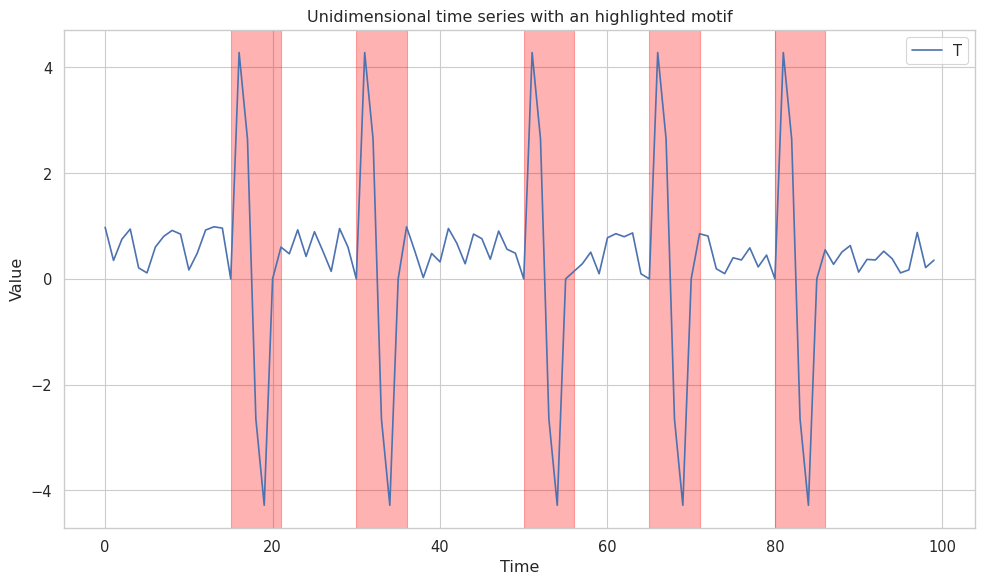

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stumpy import stump

# Set seaborn style
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create sample timeseries
timeseries = np.random.rand(100)
timeseries = timeseries.astype(float)

# Plant motifs at specific locations
motif_length = 6
motif = 4.5 * np.sin(np.linspace(0, 2 * np.pi, motif_length))

# Plant the motif at specific locations
motif_locations = [15, 30, 50, 65, 80]

for loc in motif_locations:
    timeseries[loc:loc+motif_length] = motif

m = 6
# Calculate matrix profile and find motif
mp = stump(timeseries, m=m)

# Plot the entire timeseries with planted motifs highlighted using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=timeseries, label="T")
plt.title("Unidimensional time series with an highlighted motif")
plt.xlabel("Time")
plt.ylabel("Value")

# Highlight planted motifs using rectangles
for motif_idx in motif_locations:
    plt.axvspan(motif_idx, motif_idx + motif_length, color='red', alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()


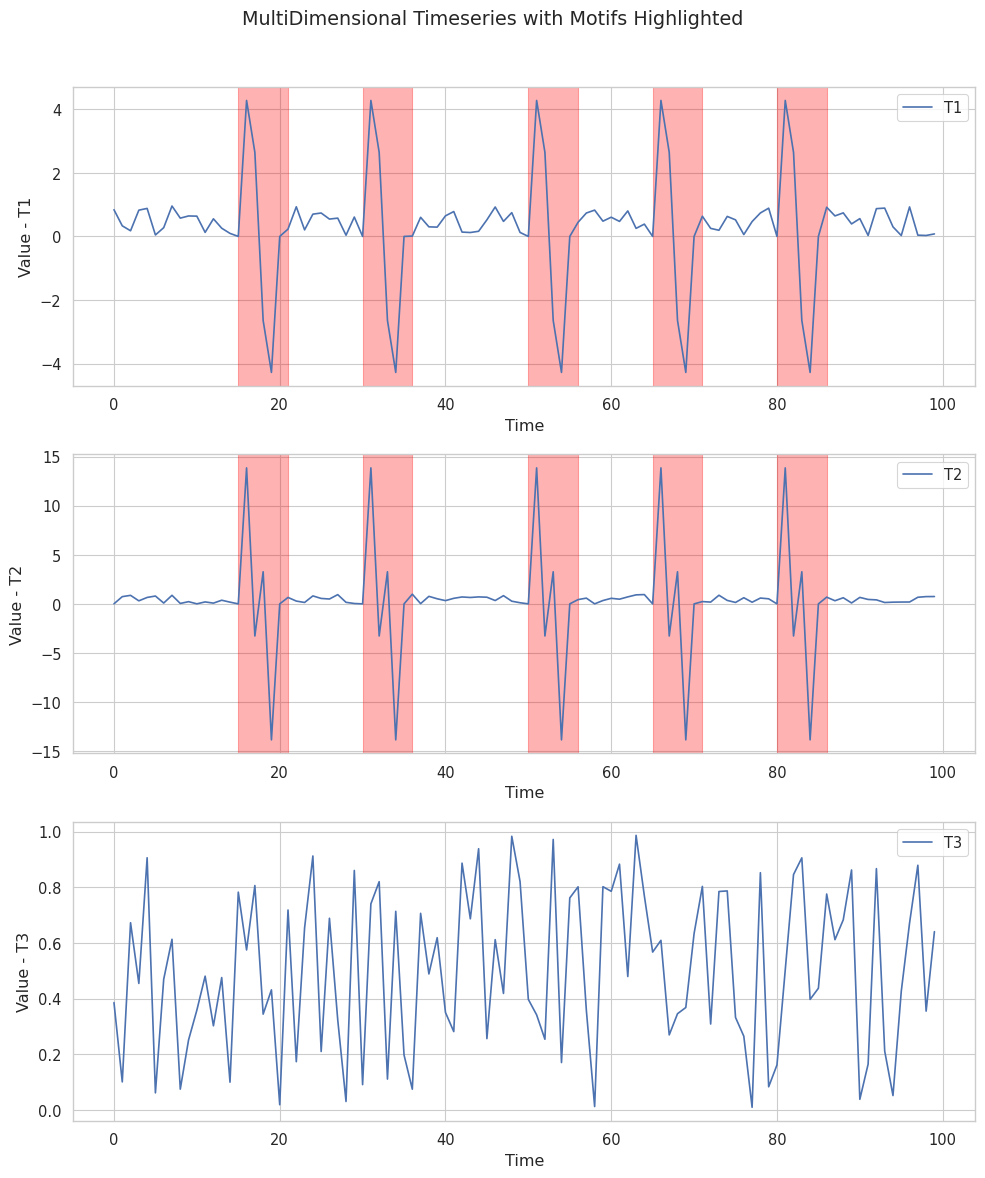

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stumpy import mstump

# Set seaborn style
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create sample 3-dimensional timeseries
timeseries_3d = np.random.rand(100, 3)
timeseries_3d[:, 0] = timeseries  # One dimension is the same as the unidimensional time series

# Plant motifs at specific locations in the second dimension
motif_length = 6
motif = 4.5 * np.tan(np.linspace(0, 2 * np.pi, motif_length))

# Plant the motif at specific locations in the second dimension
motif_locations = [15, 30, 50, 65, 80]

for loc in motif_locations:
    timeseries_3d[loc:loc+motif_length, 1] = motif

# The third dimension is just noise
timeseries_3d[:, 2] = np.random.rand(100)

m = 6
df = pd.DataFrame(timeseries_3d, columns=['T1', 'T2', 'T3'])
# Calculate matrix profile and find motifs for the first 2 dimensions
mp, indices = mstump(df, m=m)

# Plot 3 subplots, one for each dimension, and highlight motifs with rectangles
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

for i, dimension in enumerate(['T1', 'T2', 'T3']):
    axs[i].plot(df[dimension], label=dimension)

    # Highlight motifs using rectangles
    for motif_idx in motif_locations:
        if(i==2): break
        axs[i].axvspan(motif_idx, motif_idx + motif_length, color='red', alpha=0.3)

    axs[i].set_xlabel("Time")
    axs[i].set_ylabel(f"Value - {dimension}")
    axs[i].legend()

plt.suptitle("MultiDimensional Timeseries with Motifs Highlighted")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
!pip install pyts
from pyts.approximation import PiecewiseAggregateApproximation
from pyts.approximation import SymbolicAggregateApproximation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 8.6 MB/s eta 0:00:00


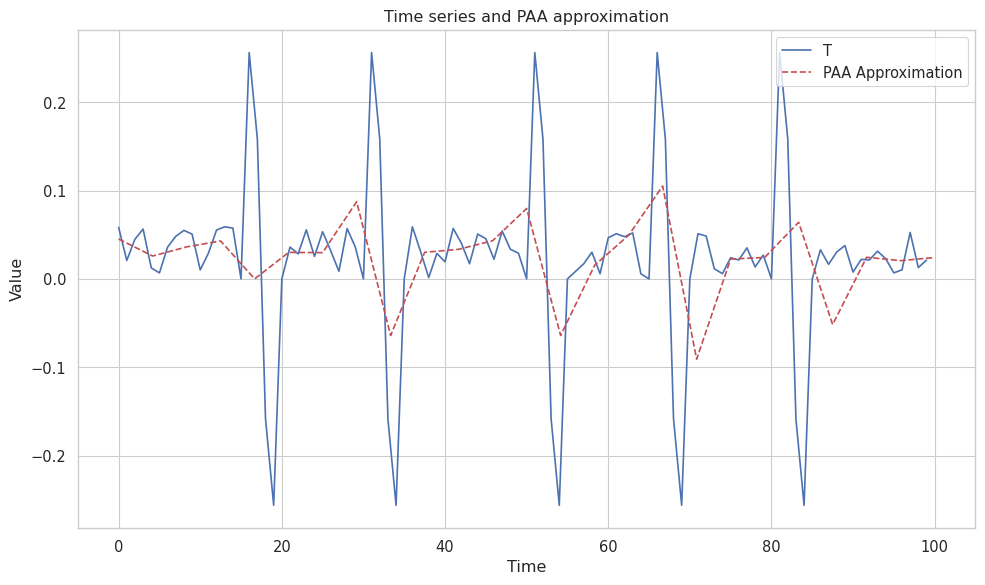

In [ ]:
paa = PiecewiseAggregateApproximation(window_size=4)
timeseries = timeseries/np.linalg.norm(timeseries) + 1e-16
t_in = timeseries.reshape(1,-1)
X_paa = paa.transform(t_in)

n_points = len(timeseries)
window_size = 5
new_x = np.linspace(0, n_points, 25)

# Plot original time series
plt.figure(figsize=(10, 6))
sns.lineplot(data=timeseries, label="T")

# Plot PAA approximation dashed
plt.plot(new_x, X_paa.flatten(), 'r--', label="PAA Approximation")

plt.title("Time series and PAA approximation")
plt.xlabel("Time")
plt.ylabel("Value")

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
sax = SymbolicAggregateApproximation(n_bins=7)
X_sax = sax.fit_transform(X_paa)

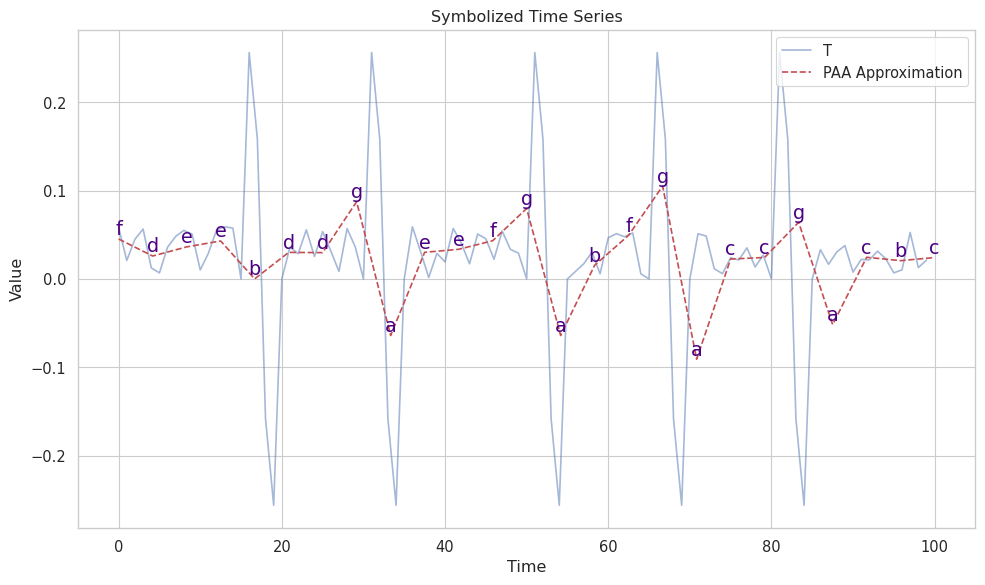

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=timeseries, label="T", alpha=0.5 )

# Plot PAA approximation dashed
plt.plot(new_x, X_paa.flatten(), 'r--', label="PAA Approximation")
for i, (x, sax_value,y) in enumerate(zip(new_x, X_sax.flatten(), X_paa.flatten())):
    plt.text(x, y, sax_value, ha='center', va='bottom', color='indigo', fontsize='large')

plt.title("Symbolized Time Series")
plt.xlabel("Time")
plt.ylabel("Value")

plt.legend()
plt.tight_layout()
plt.show()